In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data, Preprocessing, and EDA

In [19]:
df = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [5]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [6]:
df.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [7]:
# Check if duplicates exist in the dataset: No duplicates.
df['auction_id'].nunique() == len(df)

True

<AxesSubplot:xlabel='browser', ylabel='count'>

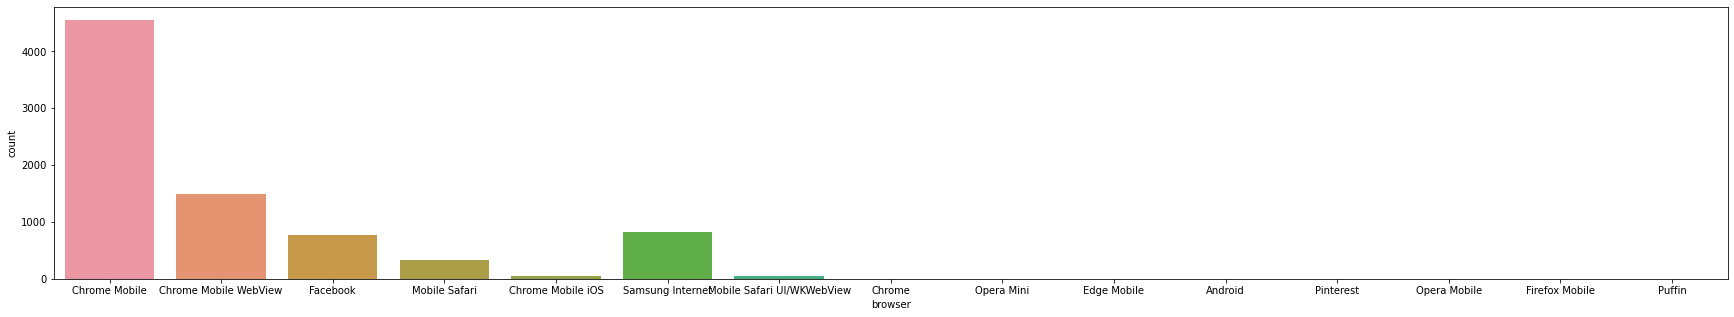

In [23]:
plt.figure(figsize=(30,5))
sns.countplot(x='browser', data=df)

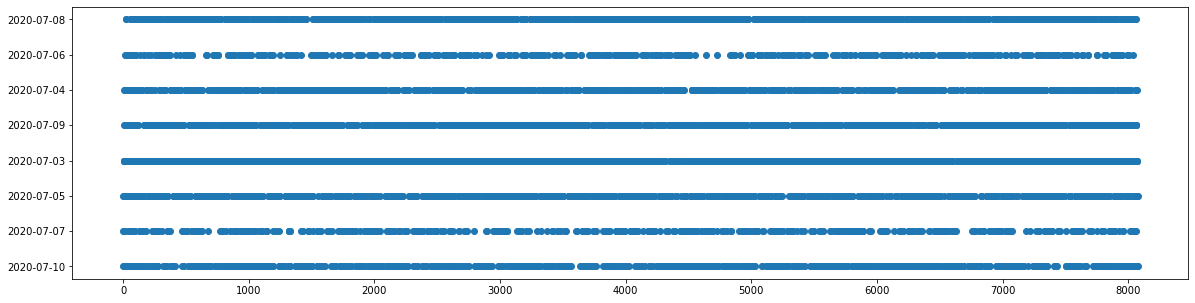

In [37]:
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(0, len(df)), df['date'])


<AxesSubplot:xlabel='experiment', ylabel='count'>

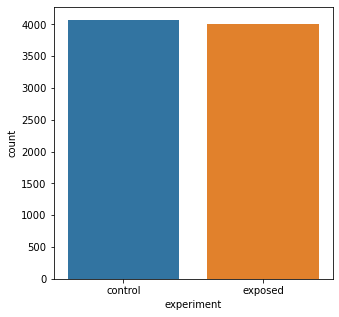

In [29]:
plt.figure(figsize=(5, 5))
sns.countplot(x='experiment', data=df, order=df['experiment'].value_counts().index)


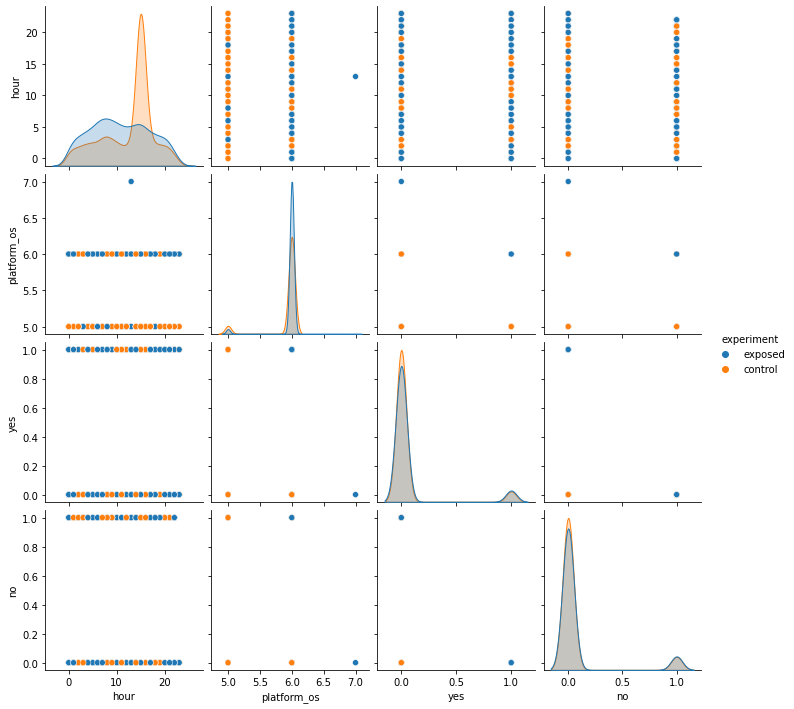

In [41]:
sns.pairplot(df, hue='experiment')

### Two problems are raised:  
* Does the new ad generate significantly more responses to their questionnaire?  
 ---We'll compare the ratio of total clicks (both 'yes' and 'no') in control and exposed groups.  
* Is the company justified in using the new ad?   
 ---The conversion rate needs to be calculated.    

##### **Problem 1**: more responses to the questionnaire?

In [8]:
# calculate the total clicks, total number in control and exposed groups
control = (df.groupby('experiment').sum()).loc['control']
click_con = control.loc['yes'] + control.loc['no']
num_con = df.groupby('experiment').nunique().loc['control']['auction_id']

exposed = (df.groupby('experiment').sum()).loc['exposed']
click_exp = exposed.loc['yes'] + exposed.loc['no']
num_exp = df.groupby('experiment').nunique().loc['exposed']['auction_id']


print("The total clicks in control group is: ", click_con)
print("The total clicks in exposed group is: ", click_exp)


The total clicks in control group is:  586
The total clicks in exposed group is:  657


In [9]:
# calculate the click ratio and std in control and exposed groups
rate_con, rate_exp = click_con/num_con, click_exp/num_exp
stdclick_con = np.sqrt(rate_con*(1-rate_con)/num_con)
stdclick_exp = np.sqrt(rate_exp*(1-rate_exp)/num_exp)
print("The standard deviation of click rate in control group is: ", round(stdclick_con, 4))
print("The standard deviation of click rate in exposed group is: ", round(stdclick_exp, 4))


The standard deviation of click rate in control group is:  0.0055
The standard deviation of click rate in exposed group is:  0.0059


Text(0, 0.5, 'Click rate')

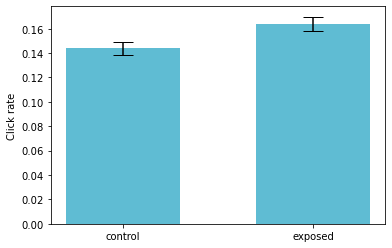

In [10]:
plt.bar(['control', 'exposed'], [rate_con, rate_exp], 
        yerr=[stdclick_con, stdclick_exp], ecolor='black', 
        color='#5FBCD3', capsize=10, width=0.6)
plt.ylabel('Click rate')

**Null hypothesis for click rate**   
H0: rate_exp - rate_exp = 0   
H1: rate_exp - rate_exp > 0  

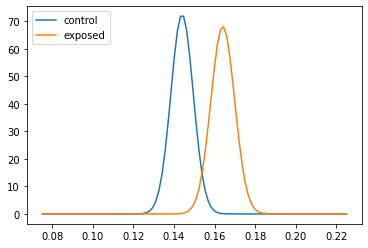

In [11]:
from scipy.stats import norm 

click_rate = np.linspace(0.075,0.225,100)
prob_con = norm(rate_con, stdclick_con).pdf(click_rate)
prob_exp = norm(rate_exp, stdclick_exp).pdf(click_rate)

plt.plot(click_rate, prob_con, label='control')
plt.plot(click_rate, prob_exp, label='exposed')
plt.legend(loc="upper left")
plt.show()


In [12]:
zscore_click = (rate_exp-rate_con)/np.sqrt(stdclick_con**2+stdclick_exp**2)
pvalue = 1-norm().cdf(zscore_click)
print(f"P value between control and exposed click rate is {pvalue:.4f}")

P value between control and exposed click rate is 0.0062


##### *Conclusion to problem 1* 
p value < 0.05, we reject the null hypothesis and conclude that new ad generate significantly more responses to their questionnaire.


#### **Probelm 2**: Is the company justified in using the new ad?   

In [13]:
# Calculate the conversion rate for both control and exposed groups respectively
conversion_con = (control.loc['yes'])/click_con

conversion_exp = (exposed.loc['yes'])/click_exp

print(f"Conversion rate in control group is {conversion_con:.3f} in {click_con} clicks")
print(f"Conversion rate in exposed group is {conversion_exp:.3f} in {click_exp} clicks")


Conversion rate in control group is 0.451 in 586 clicks
Conversion rate in exposed group is 0.469 in 657 clicks


In [14]:
# calculate the standard deviation of conversion rate in control and exposed groups
from scipy.stats import norm

std_con = np.sqrt(conversion_con*(1-conversion_con)/click_con)
std_exp = np.sqrt(conversion_exp*(1-conversion_exp)/click_exp)
print("The standard deviation of conversion in control group is: ", round(std_con, 3))
print("The standard deviation of conversion in exposed group is: ", round(std_exp, 3))


The standard deviation of conversion in control group is:  0.021
The standard deviation of conversion in exposed group is:  0.019


Text(0, 0.5, 'Click rate')

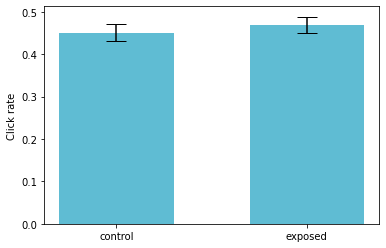

In [15]:
plt.bar(['control', 'exposed'], [conversion_con, conversion_exp],
        yerr=[std_con, std_exp], ecolor='black', color='#5FBCD3',
        capsize=10, width=0.6)
plt.ylabel('Click rate')


**Null hypothesis for conversion**  
H0: conversion_exp - conversion_con = 0  
H1: conversion_exp - conversion_con > 0  

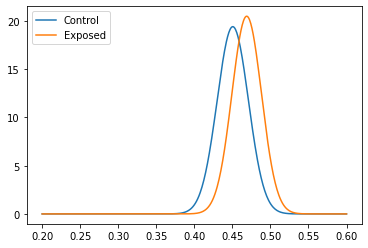

In [16]:
click_rate = np.linspace(0.2,0.6,500)
prob_a = norm(conversion_con, std_con).pdf(click_rate)
prob_b = norm(conversion_exp, std_exp).pdf(click_rate)

plt.plot(click_rate, prob_a, label="Control")
plt.plot(click_rate, prob_b, label='Exposed')
plt.legend(loc="upper left")
plt.show()


In [17]:
# get z score, p value, and confidence interval
zscore_conversion = (conversion_exp-conversion_con)/np.sqrt(std_con**2+std_exp**2)
p_conversion = 1-norm().cdf(zscore_conversion)

alpha = 0.05
z_score = norm.ppf(1-alpha)
pooled_variance = np.sqrt(std_con**2+std_exp**2)

CI = [(conversion_exp-conversion_con) - z_score*pooled_variance,
      (conversion_exp-conversion_con) + z_score*pooled_variance]

print(f"P value for conversion rate is: {p_conversion:.3f}")
print(f"The confidence interval is: {CI}")

P value for conversion rate is: 0.259
The confidence interval is: [-0.028280808359582424, 0.06485204695055076]


##### *Conclusion to Problem 2*  
P value > 0.5, we failed to reject the null hypothesis.  
Using the new Ad doesn't lead to more conversion to answer the questionare, so suggest not to use the new Ad.